In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
np.seterr(divide='raise',invalid='raise')

In [2]:
cd Geolife\ Trajectories\ 1.3

/home/me/Documents/cse523/Geolife Trajectories 1.3


In [3]:
x = pd.read_csv('Data/000/Trajectory/20081023025304.plt', skiprows=6, header=None)

In [14]:
x.head()

,0,1,2,3,4,5,6
0,39.984702,116.318417,0,492,39744.120185,2008-10-23,02:53:04
1,39.984683,116.318450,0,492,39744.120255,2008-10-23,02:53:10
2,39.984686,116.318417,0,492,39744.120313,2008-10-23,02:53:15
3,39.984688,116.318385,0,492,39744.120370,2008-10-23,02:53:20
4,39.984655,116.318263,0,492,39744.120428,2008-10-23,02:53:25


In [ ]:
# merge points with same location


In [96]:
## distance functions
def point2dist(point, line):
    linelen = np.linalg.norm(line[1]-line[0])
    if linelen==0:
        return 0
    else:
        return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/linelen

def vertical_distance(x, y):
    dist_end1 = point2dist(x[0], y)
    dist_end2 = point2dist(x[1], y)
    dist = dist_end1+dist_end2
    if dist == 0:
        return 0
    else:
        return (dist_end1**2 + dist_end2**2)/dist

def parallel_distance(x, y):
    return np.max(np.abs(x[0]-y[0]), np.abs(x[1]-y[1]))

def angular_distance(x, y):
    ylen = np.linalg.norm(y[1]-y[0])
    
    dist = 0 if ylen==0 else np.cross(x[1]-x[0], y[1]-y[0])/ylen
    if dist < 0:
        return np.linalg.norm(x[1]-x[0])
    else:
        return dist

In [116]:
# MDL cost
def mdl(data, model_indexes):
    """
    calculate mdl cost
    data the raw data
    model_indexes indexes into the raw data, data points choose by indexes are used to represent the raw data
    """
    # L(H) model cost could have multiple segments
    lh = 0
    for i in range(len(model_indexes)-1):
        dist = np.linalg.norm(data[model_indexes[i]]-data[model_indexes[i+1]])
        lh = lh + np.log2(dist) if dist!=0 else 0
    # L(D|H)
    ldh = 0
    # the index into the model_indexes, NOT into raw data
    model_index = 0
    for i in range(len(data)-1):
        if i > model_indexes[model_index+1]:
            model_index = model_index + 1

        model_i_start = model_indexes[model_index]
        model_i_end = model_indexes[model_index+1]
        
        if i!=model_i_start or i+1!=model_i_end:
            dist = vertical_distance((data[model_i_start], data[model_i_end]),(data[i], data[i+1]))* \
                angular_distance((data[model_i_start], data[model_i_end]), (data[i], data[i+1]))
            ldh = ldh + np.log2(dist) if dist!=0 else 0
    return lh + ldh

In [117]:
## MDL partition algorithm
def mdl_partition(path):
    partition_set = [path[0]]
    start_index = 0
    length = 1
    while start_index + length < len(path):
        curr_index = start_index + length
        # MDL cost if curr_index is included as a characteristic point
        mdlparcost=mdl(path[start_index:curr_index+1], (0, curr_index-start_index))
        # no partition, segmented line
        mdlnoparcost=mdl(path[start_index:curr_index+1], np.arange(curr_index-start_index+1))
        if mdlparcost > mdlnoparcost:
            partition_set = partition_set + [path[curr_index-1]]
            start_index = curr_index-1
            length = 1
        else:
            length = length + 1
    partition_set = partition_set + [path[len(path)-1]]
    return partition_set

In [119]:
partitions=(np.array(mdl_partition(x[[0,1]].values[:400])))

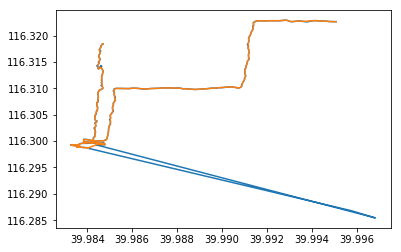

In [120]:
plt.plot(x[[0,1]][:400][0], x[[0,1]][:400][1])

plt.plot(partitions[:, 0], partitions[:, 1])

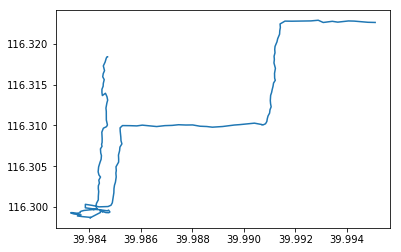

In [121]:
plt.plot(partitions[:, 0], partitions[:, 1])

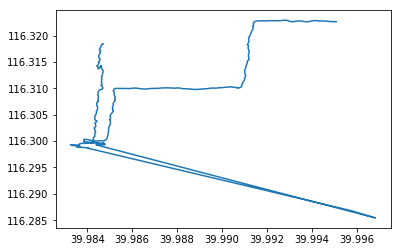

In [122]:
plt.plot(x[[0,1]][:400][0], x[[0,1]][:400][1])